# Feudal Q-Learning

**Papers**
* [Feudal Reinforcement Learning](http://www.cs.toronto.edu/~fritz/absps/dh93.pdf)
* [Feudal Q Learning](https://pdfs.semanticscholar.org/f160/10cc4ca903b27b24bc3a3df0165c8161b8ff.pdf)

In this notebook I'm exploring Feudal Reinforcement Learning. Feudal tries to mirror the hierachical aspect of a feudal fiefdom. Where we have managers, sub-manager at all levels of the hierarchy. And the manager can set tasks, reward or punish the sub-manager. In the end each manager tries to satisfy his super-manager.

## About Feudal Q-Learning

Feudal tries to map an environment in such a way that its performance drastically improves, compared to classic RL, when the Goal state changes and the environment remains the same. Instead of just having a Q matrix where each entry is a pair (s, a), with Feudal we have a stack of Q matrices. The stack is a group of levels, from Level-0 (the top one) to Level-N (bottom one). Each Level uses Q-Learning to learn its own envorinment. Each Level has its own set of states, the Level-N is just like the traditional RL where one state corresponds to an environment state, then as we go up in the stack the states are reduced by a factor of two.

**Manager, sub-manager, super-manager**: If we consider a Level-1, then: Level-1 is the manager, Level-2 is the sub-manager, and Level-0 is the super-manager.


The paper introduces the terms "reward hiding", and "information hiding" and they are very important to understand how the levels interact with each other: 
 
* **Information Hiding** - managers have no information about the means by which submanagers carry out their tasks. They do get to see the amount of reinforcement accrued from the world in the course of execution of their commands. Sub-managers also do not get any information about the tasks that their managers were set by their own managers. These restrictions can lead to sub-optimal ultimate paths, that is the price to be paid for the abstraction benefits of the hierarchy.
* **Reward Hiding** - managers should reward their sub-managers for carrying out their bidding whether or not the managers were themselves rewarded by the supermanagers. In the early stages what is important is that the sub-managers perform according to the manager's intentions, even if the manager is wrong.

<center>
<img src="https://d3i71xaburhd42.cloudfront.net/1678bd32846b1aded5b1e80a617170812e80f562/4-Figure1-1.png" alt="The Stack" width="400"/></center>

### States

For each level (except zero) the state is compost by the environment state, i.e (x, y), and the corresponding level manager's action, resulting in "(x, y, a)" 

### Actions

Like the paper the environment I used has 4 actions: N, S, E, W. The paper also introduces a Feudal specific action represented by the symbol `*`, this action means that the manager believes that the Goal is inside his current state. Level-0 only has one action, `*`, because only has one state. Beyond that, Levels from Level-1 to Level-(N-1) have the environment's 4 actions plus the `* `. And Level-N has the environment's 4 actions.

## Doubts

The paper never explains fully how the Level-0 works, the way I understand this Feudal is that each Level selects an action according to his own state. And that action will serve as a hint for the sub-manager. So, I don't understand how Level-0 can pick an action other than `*` since it only has one state. The only good reference to Level-0 is this one: "Clearly only the `*` action is available at level 0, where there is just one state". For that reason, and as I explained above, my Level-0 is just a "dummy" Q-Learning because it doesn't learn anything and only returns one action, `*`. I have tested both versions and the one I chose performs better.




In [ ]:
#!git clone https://github.com/MattChanTK/gym-maze.git && cd gym-maze && python setup.py install

In [ ]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import gym_maze

# Disable pygames video, used by gym_maze 
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

## FeudalQLearning

This is where we manage all the Feudal Levels. 



In [ ]:
class FeudalQlearning():
    
    def __init__(self, n_levels=4):
        self.n_levels = n_levels
        self.levels_stack = [NLevelQLearning(i) for i in range(n_levels)]  # 0: Level 0, 1: Level 1, etc

    def load_env(self, actions_space, observation_space):
        self.actions = [0]*self.n_levels
        self.actions[0] = 4
        self.states = []

        for i in range(self.n_levels):
            n_actions = actions_space if i == self.n_levels-1 else actions_space + 1
            self.levels_stack[i].load_env(n_actions)

    def choose_actions(self, state):
        levels_states = self.get_levels_states(state)
        all_actions = []
        for i in range(self.n_levels):
            all_actions.append(self.levels_stack[i].choose_action(levels_states[i]))
        self.actions = all_actions 
        return all_actions

    def learn(self, s, a, r, s_, done):
        levels_curr_states = self.get_levels_states(s, )        
        levels_next_states = self.get_levels_states(s_)

        for i in range(self.n_levels):
            reward = r
            if i > 0:
                reward = self.sub_manager_action_reward(a, i, r, s, s_)

            self.levels_stack[i].learn(levels_curr_states[i], a[i], reward, levels_next_states[i], done)

    def sub_manager_action_reward(self, actions, level, r, s, s_):
        if actions[level-1] == 4: # special * action
            return r
        return 0 if actions[level-1] == actions[level] and not s == s_  else -1

    def get_levels_states(self, state):
        states = [(state[0], state[1], self.actions[self.n_levels-2])]
        for i in range(self.n_levels-2, -1 , -1):
            states.append((math.ceil(states[-1][0]/2), math.ceil(states[-1][1]/2), self.actions[i-1]))
        states.reverse()
        states = [str(i) for i in states]
        return states
    
 

## NLevelQLearning 

### Q Table

I represent the Q table with a pandas Dataframe. These method is very memory intensive and I use the Dataframe in an atempt to save some space, it also allows me to use the state representation, `(x, y, manager_action)`, as the index for an easy access.

### Q-Learning update  
$$
Q(s_{t},a_{t})=Q(s_{t},a_{t})+\alpha*(r+\gamma*max_{a}Q(s_{t+1},a)-Q(s_{t}, a_{t}))
$$


**Learning Rate:** $\alpha_{k}=\frac{\alpha_{0}*\tau}{\tau+n}$

**Exploration/Exploitation:**

Just like the paper I used the softmax function:

$$
P(a) = \frac{e^{\frac{Q(s, a)}{T_{l}}}}{\sum_{v\in A_{i}}e^{\frac{Q(s, v)}{T_{l}}}}
$$
where:
$$
T_{0} = T_{MAX}\\
T_{l+1} = T_{MIN}+\beta*(T_{l}-T_{MIN})
$$

Because this is a simple exeperiment I didn't consider Goal changes and I didn't spend much of my time testing different parameters.


In [ ]:
class NLevelQLearning():

    def __init__(self, n_level):
        self.n_level = n_level
        self.alpha = 0.5
        self.gamma = 0.9
        self.epsilon = 0.5
        self.tau = 5000
        self.T_min = 0.2
        self.T_max = 10000
        self.T_l = self.T_max
        self.beta = 0.9995
        self.n = 0

    def load_env(self, n_actions):
        self.actions = list(range(n_actions))
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.curr_state = ""
        self.curr_action = 0

    def choose_action(self, s):
        if self.n_level == 0:
            return 4

        if not self.state_exists(s):
            self.add_state(s)
        soft_dist = self._softmax(s)
    
        action = np.random.choice(self.actions, p=soft_dist)

        return action

    def learn(self, s, a, r, s_, done):
        if self.n_level == 0:
            return   

        if not self.state_exists(s):
            self.add_state(s)
        if not self.state_exists(s_):
            self.add_state(s_)
        
        self.n += 1
        alpha_k = (self.alpha * self.tau) / (self.tau + self.n)
        
        td_target = r + self.gamma * self.q_table.loc[s_].max()

        self.q_table.loc[s, a] = self.q_table.loc[s, a] + alpha_k * (td_target - self.q_table.loc[s, a]) 


    def state_exists(self, state):
        return state in self.q_table.index

    def add_state(self, state_name):
        self.q_table = self.q_table.append(
            pd.Series(
                [self.q_start_value()] * len(self.actions),
                index=self.q_table.columns,
                name=state_name,
                dtype=np.float64
                )
            )
    
    def q_start_value(self):
        return 1

    def _softmax(self, s):
      dist = []
      values = []
      denominator = 0

      for a in range(len(self.actions)):
        val = np.exp(self.q_table.loc[s, a]/self.T_l)
        values.append(val)
        denominator += val
      
      for val in values:
        dist.append(val/denominator)
      self.T_l = self.T_min + self.beta * (self.T_l - self.T_min)
      return np.array(dist)

## Train

Nothing major here just the standard environment iteraction. 

In [ ]:
def wrap_state(state):
    return (int(state[0]), int(state[1]))

def train():
    NUM_EPISODES = 5000
    BATCH_SIZE = 20

    env = gym.make("maze-sample-5x5-v0")
    env_action = {0: 'N', 1: 'S', 2: 'E', 3: 'W'}

    # Agent
    agent = FeudalQlearning()
    agent.load_env(env.action_space.n, 0)

    n_steps_arr = np.empty(0, dtype=int)

    batch_avg = 0
    batch_n = 0

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obs = env.reset()

        total_reward = 0
        n_steps = 0
        done = False

        while not done:
            s = wrap_state(obs)

            # Select an action
            actions = agent.choose_actions(s)
            agent_action = actions[-1]

            # Execute the action
            obs, reward, done, _ = env.step(env_action[agent_action])
            s_ = wrap_state(obs)

            total_reward += reward
            n_steps += 1

            agent.learn(s, actions, reward, s_, done)
        
        batch_n += 1
        batch_avg += n_steps/BATCH_SIZE

        if batch_n % BATCH_SIZE == 0:
          print("Steps: " + str(batch_avg))
          n_steps_arr = np.append(n_steps_arr, batch_avg)
          batch_avg = 0

    env.close()

    x = np.arange(1,(NUM_EPISODES/BATCH_SIZE)+1)
    plt.plot(x,n_steps_arr)
    plt.show()


Steps: 615.9
Steps: 343.89999999999986
Steps: 134.0
Steps: 92.79999999999998
Steps: 74.49999999999999
Steps: 90.05000000000003
Steps: 95.7
Steps: 95.0
Steps: 81.85000000000001
Steps: 106.24999999999999
Steps: 87.9
Steps: 79.15
Steps: 83.55
Steps: 81.19999999999999
Steps: 75.89999999999999
Steps: 82.30000000000001
Steps: 63.000000000000014
Steps: 79.69999999999999
Steps: 61.199999999999996
Steps: 71.84999999999998
Steps: 70.85
Steps: 58.90000000000001
Steps: 88.65
Steps: 54.949999999999996
Steps: 56.45
Steps: 70.2
Steps: 79.29999999999997
Steps: 60.400000000000006
Steps: 51.35
Steps: 64.64999999999999
Steps: 55.04999999999999
Steps: 66.94999999999999
Steps: 68.14999999999999
Steps: 46.69999999999998
Steps: 69.45
Steps: 55.849999999999994
Steps: 45.25
Steps: 58.24999999999999
Steps: 53.15
Steps: 61.24999999999999
Steps: 61.949999999999996
Steps: 68.64999999999999
Steps: 57.25
Steps: 37.1
Steps: 58.150000000000006
Steps: 57.5
Steps: 62.949999999999996
Steps: 52.85
Steps: 47.30000000000000

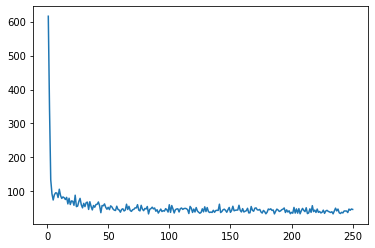

In [ ]:
train()

## Final Thoughts

**Implementation:** For very big environments the Boltzmann exploration might not be enough, since it realies on the agent capability to reach all states multiple time with somewhat random actions. 

**Idea:** I really like the ideia, it is very interesting and all the work inspired by it is also very compelling, for example, FeudalNetworks. 
The search for an agent that can learn to perform tasks in a hierarchical way is very important in my opinion, I am not sure this aproach is the right way, but is certainly a start. 

